# Setup and Configuration

In [ ]:
!pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.5 MB/s eta 0:00:00


In [ ]:
!pip install -U -q evaluate transformers datasets>=2.14.5 accelerate>=0.27 mlflow 2>/dev/null

In [ ]:
import os
import warnings
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    f1_score
)
from imblearn.over_sampling import RandomOverSampler
from pathlib import Path
from tqdm import tqdm
import gc
import numpy as np
import pandas as pd
from datasets import Dataset, Image, ClassLabel
from transformers import (
    TrainingArguments,
    Trainer,
    ViTImageProcessor,
    ViTForImageClassification,
    DefaultDataCollator
)
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomRotation,
    RandomResizedCrop,
    RandomHorizontalFlip,
    RandomAdjustSharpness,
    Resize,
    ToTensor
)
from PIL import ImageFile


In [ ]:

warnings.filterwarnings("ignore")
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
%%writefile kaggle.json
{"username":"akashsampath16","key":"1bc78388ab649a1152c2a1bd4721a367"}

Writing kaggle.json


# Data Loading and Preprocessing


In [ ]:
def download_kaggle_dataset(dataset_path):

    os.system('pip install -q kaggle')

    if not os.path.isfile('kaggle.json'):
        print("kaggle.json file not found. Please upload it.")
        return

    os.system('mkdir -p ~/.kaggle')
    os.system('cp kaggle.json ~/.kaggle/')
    os.system('chmod 600 ~/.kaggle/kaggle.json')

    os.system(f'kaggle datasets download -d {dataset_path}')

    zip_file = f'{dataset_path.split("/")[-1]}.zip'
    os.system(f'unzip -q {zip_file}')

download_kaggle_dataset('manjilkarki/deepfake-and-real-images')


In [ ]:
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from pathlib import Path
import gc

def load_and_prepare_data(dataset_path):
    """Load images and labels from the given dataset path, and prepare the dataset."""
    file_names = []
    labels = []

    for file in sorted(Path(dataset_path).glob('*/*/*.*')):
        label = file.parts[-2]
        labels.append(label)
        file_names.append(str(file))

    df = pd.DataFrame({"image": file_names, "label": labels})

    ros = RandomOverSampler(random_state=83)
    df_balanced, y_resampled = ros.fit_resample(df[['image']], df['label'])

    df_balanced['label'] = y_resampled

    del y_resampled
    gc.collect()

    return df_balanced

dataset_path = '/content/Dataset'
df = load_and_prepare_data(dataset_path)


In [ ]:
print(df.shape)

(190402, 2)


In [ ]:
df.head()

,image,label
0,/content/Dataset/Test/Fake/fake_0.jpg,Fake
1,/content/Dataset/Test/Fake/fake_1.jpg,Fake
2,/content/Dataset/Test/Fake/fake_10.jpg,Fake
3,/content/Dataset/Test/Fake/fake_100.jpg,Fake
4,/content/Dataset/Test/Fake/fake_1000.jpg,Fake


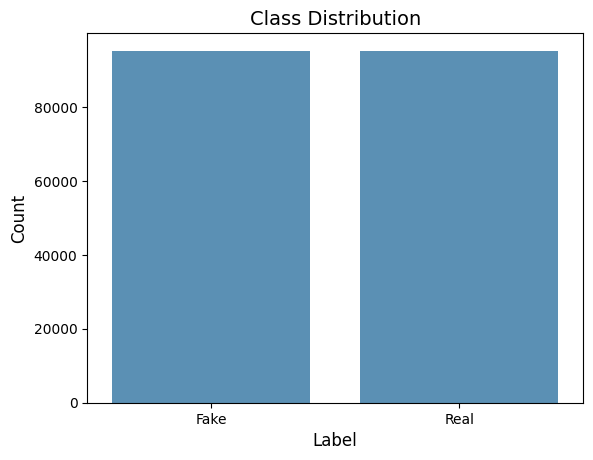

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

label_counts = df['label'].value_counts()

sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Label', fontsize=12)
plt.title('Class Distribution', fontsize=14)
plt.show()


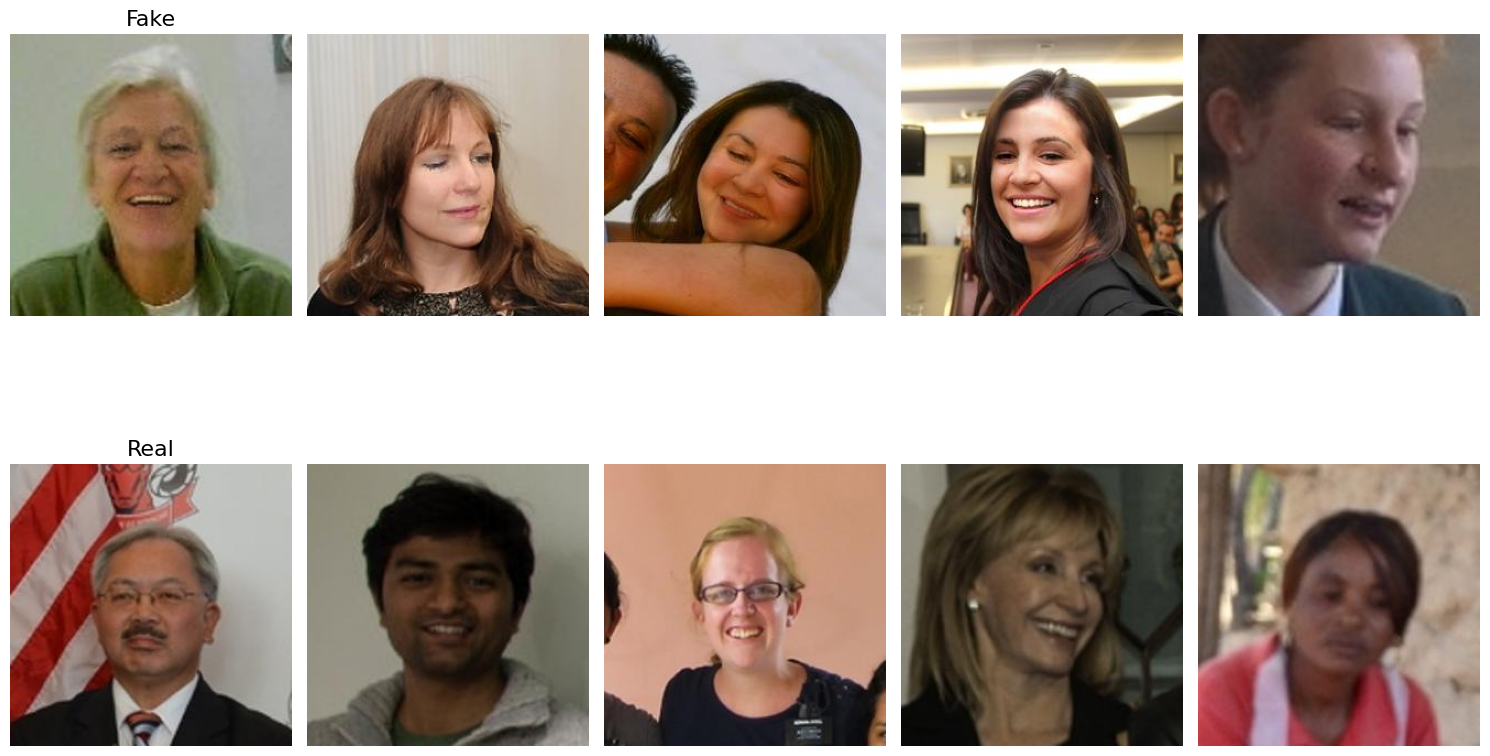

In [ ]:

def display_sample_images(df, label_column='label', n_samples=5):
    """
    Displays sample images for each class in the dataset.

    Args:
        df (pd.DataFrame): The dataframe containing image paths and labels.
        label_column (str): The name of the label column.
        n_samples (int): Number of samples to display per class.
    """
    labels = df[label_column].unique()
    plt.figure(figsize=(15, 5 * len(labels)))

    for idx, label in enumerate(labels):
        subset = df[df[label_column] == label].sample(n=n_samples, random_state=42)
        for i, img_path in enumerate(subset['image']):
            plt_idx = idx * n_samples + i + 1
            plt.subplot(len(labels), n_samples, plt_idx)
            image = plt.imread(img_path)
            plt.imshow(image)
            plt.axis('off')
            if i == 0:
                plt.title(label, fontsize=16)
    plt.tight_layout()
    plt.show()

display_sample_images(df, 'label', n_samples=5)


# Data Preperation and Transformation

In [ ]:
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
import gc

def separate_and_oversample(df, target_column='label', random_state=83):
    """
    Separates target variable and features, and performs random oversampling on the minority class.

    Args:
    df (pd.DataFrame): The input dataframe.
    target_column (str): The name of the target column.
    random_state (int): Random state for reproducibility.

    Returns:
    pd.DataFrame: A dataframe with oversampled data.
    """
    y = df[[target_column]]
    features = df.drop(target_column, axis=1)

    ros = RandomOverSampler(random_state=random_state)
    features_resampled, y_resampled = ros.fit_resample(features, y)

    features_resampled[target_column] = y_resampled

    return features_resampled

def perform_garbage_collection():
    """
    Performs garbage collection to free up memory.
    """
    gc.collect()


df = separate_and_oversample(df, 'label', 83)

perform_garbage_collection()

print(df.shape)


(190402, 2)


In [ ]:

from datasets import Dataset, ClassLabel
from torchvision.transforms import Compose, Resize, RandomRotation, RandomAdjustSharpness, ToTensor, Normalize

from datasets import Dataset, Features, Value, Image

def create_dataset_from_dataframe(df):
    """Create a dataset from a Pandas DataFrame."""

    features = Features({
        'image': Image(),
        'label': Value('string') 
    })

    dataset = Dataset.from_pandas(df, features=features)
    return dataset

def print_label_subset(labels_list):
    """Print a subset of labels to inspect their content."""
    labels_subset = labels_list[:5]
    print(labels_subset)

def create_label_mappings(labels_list):
    """Create mappings between labels and IDs."""
    label2id, id2label = {}, {}
    for i, label in enumerate(labels_list):
        label2id[label] = i
        id2label[i] = label
    return label2id, id2label

def map_labels_to_ids(dataset, ClassLabels):
    """Map labels to IDs in the dataset."""
    def map_label2id(example):
        example['label'] = ClassLabels.str2int(example['label'])
        return example

    dataset = dataset.map(map_label2id, batched=True)
    return dataset.cast_column('label', ClassLabels)

def split_dataset(dataset):
    """Split the dataset into training and testing sets."""
    return dataset.train_test_split(test_size=0.05, shuffle=True, stratify_by_column="label")

def create_vit_processor(model_str):
    """Create a processor for ViT model input."""
    processor = ViTImageProcessor.from_pretrained(model_str)
    return processor, processor.image_mean, processor.image_std, processor.size["height"]

def define_transforms(size, image_mean, image_std):
    """Define transformations for training and validation data."""
    _train_transforms = Compose([
        Resize((size, size)),
        RandomRotation(30),
        RandomAdjustSharpness(2),
        ToTensor(),
        Normalize(mean=image_mean, std=image_std)
    ])

    _val_transforms = Compose([
        Resize((size, size)),
        ToTensor(),
        Normalize(mean=image_mean, std=image_std)
    ])

    return _train_transforms, _val_transforms

def set_dataset_transforms(train_data, test_data, train_transforms, val_transforms):
    """Set transformations for training and test/validation datasets."""
    train_data.set_transform(lambda examples: apply_transforms(examples, train_transforms))
    test_data.set_transform(lambda examples: apply_transforms(examples, val_transforms))

def apply_transforms(examples, transforms):
    """Apply transformations to a batch of examples."""
    examples['pixel_values'] = [transforms(image.convert("RGB")) for image in examples['image']]
    return examples

In [ ]:
labels_list = ['Real', 'Fake']

In [ ]:

dataset = create_dataset_from_dataframe(df)

print_label_subset(labels_list)

label2id, id2label = create_label_mappings(labels_list)
print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

dataset = map_labels_to_ids(dataset, ClassLabels)

split_dataset_result = split_dataset(dataset)
train_data = split_dataset_result['train']
test_data = split_dataset_result['test']

model_str = "dima806/deepfake_vs_real_image_detection"
processor, image_mean, image_std, size = create_vit_processor(model_str)
print("Size: ", size)

_train_transforms, _val_transforms = define_transforms(size, image_mean, image_std)

set_dataset_transforms(train_data, test_data, _train_transforms, _val_transforms)

['Real', 'Fake']
Mapping of IDs to Labels: {0: 'Real', 1: 'Fake'} 

Mapping of Labels to IDs: {'Real': 0, 'Fake': 1}


Map:   0%|          | 0/190402 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/190402 [00:00<?, ? examples/s]

preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

Size:  224


In [ ]:

import pandas as pd
print("Label to ID mapping:", label2id)
print("ID to label mapping:", id2label)

data = {'Label': labels_list, 'ID': list(range(len(labels_list)))}
table = pd.DataFrame(data)

print(table.to_string())


Label to ID mapping: {'Real': 0, 'Fake': 1}
ID to label mapping: {0: 'Real', 1: 'Fake'}
  Label  ID
0  Real   0
1  Fake   1


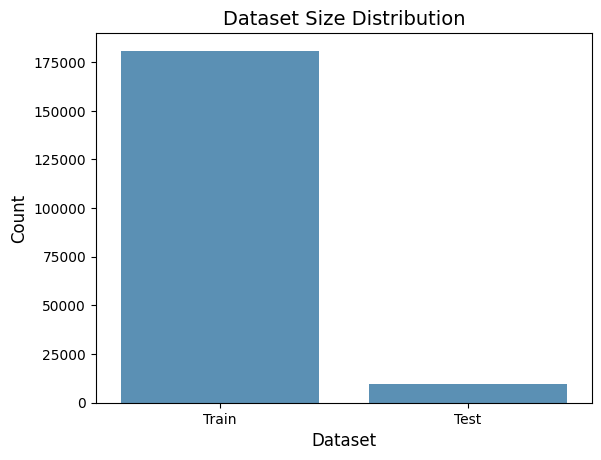

In [ ]:
import matplotlib.pyplot as plt
sns.barplot(x=['Train', 'Test'], y=[len(train_data), len(test_data)], alpha=0.8)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Dataset', fontsize=12)
plt.title('Dataset Size Distribution', fontsize=14)
plt.show()


In [ ]:
train_data

Dataset({
    features: ['image', 'label'],
    num_rows: 180881
})

In [ ]:
test_data

Dataset({
    features: ['image', 'label'],
    num_rows: 9521
})

# Model Creation and Training

In [ ]:
from sklearn.metrics import accuracy_score

# Define a function 'compute_metrics' to calculate evaluation metrics
def compute_metrics(eval_pred):
    predictions, label_ids = eval_pred
    predicted_labels = predictions.argmax(axis=1)
    acc_score = accuracy_score(label_ids, predicted_labels)
    return {"accuracy": acc_score}


# Configure and load the pre-trained ViT model
model = ViTForImageClassification.from_pretrained(model_str, num_labels=2)

model.config.id2label = id2label
model.config.label2id = label2id
print(f"Trainable Parameters: {model.num_parameters(only_trainable=True) / 1e6} million")

# Check for GPU availability
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"Device Name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")


config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

Trainable Parameters: 85.800194 million
CUDA Available: True
Device Name: Tesla T4


In [ ]:

output_dir = "deepfake_vs_real_image_detection"
num_train_epochs = 1
training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch",
    learning_rate=5e-6,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=16,
    num_train_epochs=num_train_epochs,
    weight_decay=0.02,
    warmup_steps=50,
    remove_unused_columns=False,
    save_strategy='epoch',
    load_best_model_at_end=True,
    save_total_limit=1,
    report_to="none"
)

def collate_fn(examples):
    pixel_values = torch.stack([example['pixel_values'] for example in examples])
    labels = torch.tensor([example['label'] for example in examples])
    return {'pixel_values': pixel_values, 'labels': labels}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,  
    eval_dataset=test_data,    
    data_collator=collate_fn,
    compute_metrics=compute_metrics
)



In [ ]:

trainer.evaluate()
trainer.train()
evaluation_results = trainer.evaluate()

prediction_results = trainer.predict(test_data)
print("Prediction Metrics:", prediction_results.metrics)

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
1,0.017700,0.024093,0.003300,0.991492


Prediction Metrics: {'test_loss': 0.024093104526400566, 'test_model_preparation_time': 0.0033, 'test_accuracy': 0.9914924902846339, 'test_runtime': 123.282, 'test_samples_per_second': 77.229, 'test_steps_per_second': 4.834}


# Model Evaluation and Saving

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import shutil
import os
from transformers import pipeline

def predict_and_print_metrics(trainer, test_data):
    """Use the trained 'trainer' to make predictions on 'test_data' and print metrics."""
    outputs = trainer.predict(test_data)
    print(outputs.metrics)
    return outputs.label_ids, outputs.predictions.argmax(1)

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    """Plot a confusion matrix."""
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.0f'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def calculate_and_print_scores(y_true, y_pred):
    """Calculate and print accuracy and F1 score."""
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")

def display_classification_report(y_true, y_pred, labels_list):
    """Display classification report."""
    print("\nClassification report:\n")
    print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

def save_and_zip_model(trainer, model_directory, zip_file_path):
    """Save the trained model and zip it."""
    trainer.save_model(model_directory)
    if os.path.exists(model_directory):
        shutil.make_archive(base_name=zip_file_path.replace('.zip', ''), format='zip', root_dir=model_directory)
        print(f"Model zipped successfully at: {zip_file_path}")
    else:
        print(f"Directory not found: {model_directory}")

def display_image_and_predict(pipe, test_data, index, id2label):
    """Display an image and make a prediction."""
    image = test_data[index]["image"]
    plt.imshow(image)
    plt.show()
    print(pipe(image))
    print(id2label[test_data[index]["label"]])


{'test_loss': 0.024093104526400566, 'test_model_preparation_time': 0.0033, 'test_accuracy': 0.9914924902846339, 'test_runtime': 135.516, 'test_samples_per_second': 70.257, 'test_steps_per_second': 4.398}
Accuracy: 0.9915
F1 Score: 0.9915


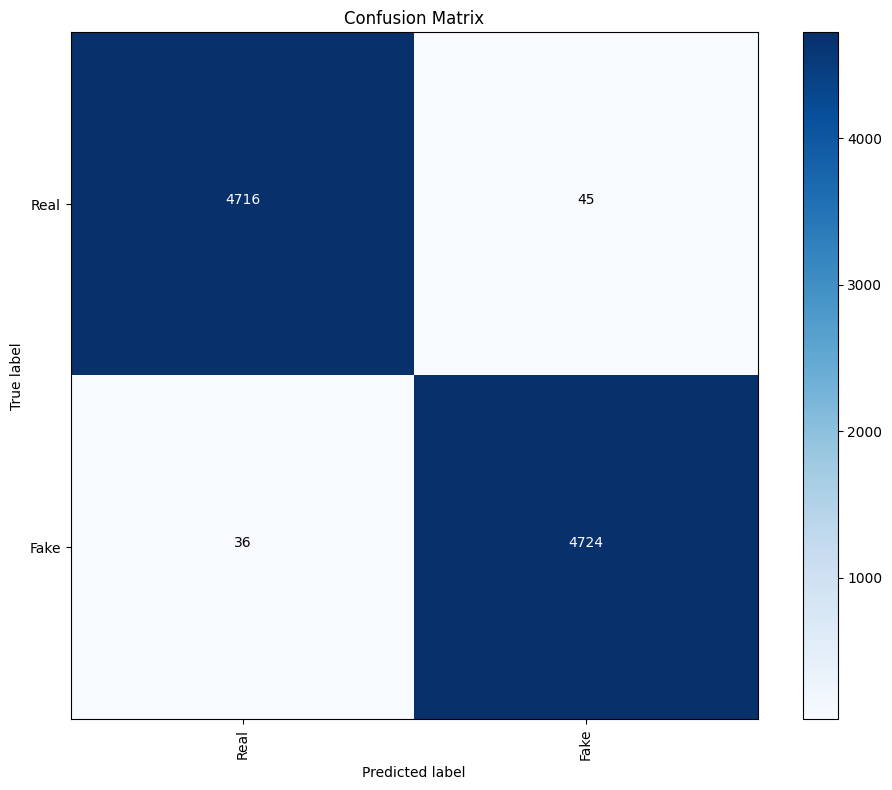


Classification report:

              precision    recall  f1-score   support

        Real     0.9924    0.9905    0.9915      4761
        Fake     0.9906    0.9924    0.9915      4760

    accuracy                         0.9915      9521
   macro avg     0.9915    0.9915    0.9915      9521
weighted avg     0.9915    0.9915    0.9915      9521



In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report

def compute_metrics(eval_pred):
    predictions, label_ids = eval_pred
    predicted_labels = predictions.argmax(axis=1)
    acc_score = accuracy_score(label_ids, predicted_labels)
    f1 = f1_score(label_ids, predicted_labels, average='macro')

    if len(set(label_ids)) == 2:
        roc_auc = roc_auc_score(label_ids, predictions[:, 1])
    else:
        roc_auc = roc_auc_score(label_ids, predictions, multi_class="ovr")

    return {"accuracy": acc_score, "f1": f1, "roc_auc": roc_auc}

y_true, y_pred = predict_and_print_metrics(trainer, test_data)
calculate_and_print_scores(y_true, y_pred)

cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, labels_list)

display_classification_report(y_true, y_pred, labels_list)


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


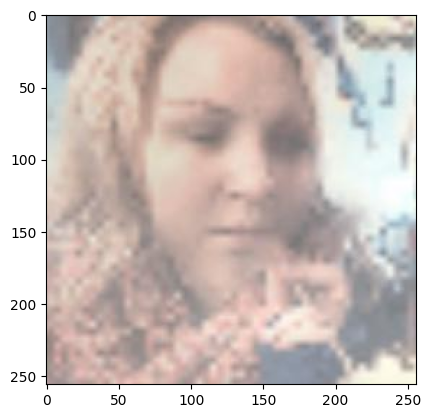

[{'label': 'Fake', 'score': 0.9726414084434509}, {'label': 'Real', 'score': 0.022498827427625656}]
Fake


In [ ]:
from transformers import pipeline

pipe = pipeline("image-classification", model=model, feature_extractor=processor)

test_index = 0  
display_image_and_predict(pipe, test_data, test_index, id2label)


In [ ]:
import shutil
import os

def save_and_zip_model(trainer, model_directory, zip_file_path):
    """Save the trained model and zip it."""
    trainer.save_model(model_directory)
    if os.path.exists(model_directory):
        shutil.make_archive(base_name=zip_file_path.replace('.zip', ''), format='zip', root_dir=model_directory)
        print(f"Model zipped successfully at: {zip_file_path}")
    else:
        print(f"Directory not found: {model_directory}")

model_directory = "/content/deepfake_model"
zip_file_path = '/content/deepfake_model.zip'
save_and_zip_model(trainer, model_directory, zip_file_path)


Model zipped successfully at: /content/deepfake_model.zip
